In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import wilcoxon
import time
import shap
import xgboost
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [2]:
df.shape

(2139, 18)

In [3]:
df.columns

Index(['Unnamed: 0', 'age', 'wtkg', 'karnof', 'cd40', 'cid', 'trt_ZDV + ddI',
       'trt_ZDV only', 'trt_ddI only', 'hemo_no hemophilia',
       'homo_no homosexual', 'drugs_no IV drugs use',
       'z30_no ZDV-Therapy 30 days befor randomisation', 'race_White',
       'gender_Male', 'strat_> 52 weeks', 'strat_Antiretroviral Naive',
       'symptom_symtomatic'],
      dtype='object')

In [23]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1)

In [24]:
df.head(10)

,age,wtkg,karnof,cd40,cid,trt_ZDV + ddI,trt_ZDV only,trt_ddI only,hemo_no hemophilia,homo_no homosexual,drugs_no IV drugs use,z30_no ZDV-Therapy 30 days befor randomisation,race_White,gender_Male,strat_> 52 weeks,strat_Antiretroviral Naive,symptom_symtomatic
0,48,89.8128,100,422,0,0,0,0,1,1,1,1,1,0,0,1,0
1,61,49.4424,90,162,1,0,0,1,1,1,1,0,1,0,1,0,0
2,45,88.4520,90,326,0,0,0,1,1,0,0,0,1,1,1,0,0
3,47,85.2768,100,287,0,0,0,1,1,0,1,0,1,1,1,0,0
4,43,66.6792,100,504,0,0,1,0,1,0,1,0,1,1,1,0,0
5,46,88.9056,100,235,0,1,0,0,1,0,0,0,1,1,1,0,0
6,31,73.0296,100,244,1,0,1,0,1,0,1,0,1,1,1,0,0
7,41,66.2256,100,401,0,0,1,0,1,0,0,0,1,1,1,0,0
8,40,82.5552,90,214,1,0,0,1,1,0,1,0,1,1,1,0,1
9,35,78.0192,100,221,1,0,1,0,1,0,1,0,1,1,1,0,0


In [5]:
df["cid"] = df["cid"].replace({'failure': 1, 'censoring': 0})

In [25]:
df.head(5)

,age,wtkg,karnof,cd40,cid,trt_ZDV + ddI,trt_ZDV only,trt_ddI only,hemo_no hemophilia,homo_no homosexual,drugs_no IV drugs use,z30_no ZDV-Therapy 30 days befor randomisation,race_White,gender_Male,strat_> 52 weeks,strat_Antiretroviral Naive,symptom_symtomatic
0,48,89.8128,100,422,0,0,0,0,1,1,1,1,1,0,0,1,0
1,61,49.4424,90,162,1,0,0,1,1,1,1,0,1,0,1,0,0
2,45,88.4520,90,326,0,0,0,1,1,0,0,0,1,1,1,0,0
3,47,85.2768,100,287,0,0,0,1,1,0,1,0,1,1,1,0,0
4,43,66.6792,100,504,0,0,1,0,1,0,1,0,1,1,1,0,0


## Datenspliting

In [26]:
X=df.drop(['cid'],axis=1)
y=df['cid']

### test_size = 0.3

Dieser Kennwert war initial für das Datenspliting. Dabei ergaben sich Unterschiede in den Test- und Trainingsdaten insbesondere im Bezug auf `cd40`. So entstand die darauf folgende `test_size`-Optimierung.

In [8]:
from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.3,random_state=52)

print('X3 Train: {}'.format(X3_train.shape)) 
print('Y3 Train: {}'.format(y3_train.shape)) 
print('X3 Test: {}'.format(X3_test.shape)) 
print('Y3 Test: {}'.format(y3_test.shape))


X3 Train: (1497, 17)
Y3 Train: (1497,)
X3 Test: (642, 17)
Y3 Test: (642,)


### test_size = 0.2

In [9]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2,random_state=52)

print('X2 Train: {}'.format(X2_train.shape)) 
print('Y2 Train: {}'.format(y2_train.shape)) 
print('X2 Test: {}'.format(X2_test.shape)) 
print('Y2 Test: {}'.format(y2_test.shape))

X2 Train: (1711, 17)
Y2 Train: (1711,)
X2 Test: (428, 17)
Y2 Test: (428,)


### test_size = 0.4

In [10]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, test_size=0.4,random_state=52)

print('X4 Train: {}'.format(X4_train.shape)) 
print('Y4 Train: {}'.format(y4_train.shape)) 
print('X4 Test: {}'.format(X4_test.shape)) 
print('Y4 Test: {}'.format(y4_test.shape))

X4 Train: (1283, 17)
Y4 Train: (1283,)
X4 Test: (856, 17)
Y4 Test: (856,)


### test_size = 0.1

In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.1,random_state=52)

print('X1 Train: {}'.format(X1_train.shape)) 
print('Y1 Train: {}'.format(y1_train.shape)) 
print('X1 Test: {}'.format(X1_test.shape)) 
print('Y1 Test: {}'.format(y1_test.shape))

X1 Train: (1925, 16)
Y1 Train: (1925,)
X1 Test: (214, 16)
Y1 Test: (214,)


### Verleich Trainings- und Testdaten

In [ ]:
#import numpy as np
#import scipy.stats
#from scipy.stats import wilcoxon

In [28]:
numset = df[['age', 'wtkg', 'karnof', 'cd40']]
#dfnum = pd.df.select(numset, axis=1)


In [29]:
numset.head()

,age,wtkg,karnof,cd40
0,48,89.8128,100,422
1,61,49.4424,90,162
2,45,88.4520,90,326
3,47,85.2768,100,287
4,43,66.6792,100,504


In [30]:
def calculate_mean(dataframe, feat):
        return np.mean(dataframe[feat].to_numpy())



for feature in numset.columns:
    print("test_size:  {}, Feature: {}, mean train: {}, mean test: {}".format(0.3, feature, calculate_mean(X3_train, feature), calculate_mean(X3_test, feature)))
    
    print("test_size:  {}, Feature: {}, mean train: {}, mean test: {}".format(0.2, feature, calculate_mean(X2_train, feature), calculate_mean(X2_test, feature)))
    
    print("test_size:  {}, Feature: {}, mean train: {}, mean test: {}".format(0.4, feature, calculate_mean(X4_train, feature), calculate_mean(X4_test, feature)))
    
    print("test_size:  {}, Feature: {}, mean train: {}, mean test: {}".format(0.1, feature, calculate_mean(X1_train, feature), calculate_mean(X1_test, feature)))
    
    
    print("test_size:  {}, Feature: {}, Differenz: {}".format(0.3, feature, (calculate_mean(X3_train, feature) - calculate_mean(X3_test, feature)) ))
    
    print("test_size:  {}, Feature: {}, Differenz: {}".format(0.2, feature, (calculate_mean(X2_train, feature) - calculate_mean(X2_test, feature))))
    
    print("test_size:  {}, Feature: {}, Differenz: {}".format(0.4, feature, (calculate_mean(X4_train, feature) - calculate_mean(X4_test, feature))))
    
    print("test_size:  {}, Feature: {}, Differenz: {}".format(0.1, feature, (calculate_mean(X1_train, feature) - calculate_mean(X1_test, feature))))    

test_size:  0.3, Feature: age, mean train: 35.30995323981296, mean test: 35.10436137071651
test_size:  0.2, Feature: age, mean train: 35.27235534774985, mean test: 35.151869158878505
test_size:  0.4, Feature: age, mean train: 35.41543257989088, mean test: 34.99766355140187
test_size:  0.1, Feature: age, mean train: 35.295064935064936, mean test: 34.82710280373832
test_size:  0.3, Feature: age, Differenz: 0.20559186909645177
test_size:  0.2, Feature: age, Differenz: 0.12048618887134666
test_size:  0.4, Feature: age, Differenz: 0.4177690284890119
test_size:  0.1, Feature: age, Differenz: 0.46796213132661535
test_size:  0.3, Feature: wtkg, mean train: 75.24372622578491, mean test: 74.84919165109035
test_size:  0.2, Feature: wtkg, mean train: 75.29526630040911, mean test: 74.4458844859813
test_size:  0.4, Feature: wtkg, mean train: 75.1445171005456, mean test: 75.09652308411215
test_size:  0.1, Feature: wtkg, mean train: 75.25937994805194, mean test: 73.91931214953271
test_size:  0.3, Feat

`test_size` = 0.4 teilt die stetigen Parameter - insbesondere `cd40` - in die in etwa gleichen Verhältnisse am besten. 
Es ist natürlich zu überlegen, was an der Stelle besser geeignet ist. `0.4` ist schon viel für die Testdaten. In Absolutzahlen sind es `1283` vs. `856`. Das `n` ist verhältnismässig klein für die Trainingsdaten-Größe. 


<span style=color:green>Kompromiss:</span> `test_size`= 0.1 trennt geringfügig schlechter ein, bietet jedoch eine gute Größe für die Traingnsdaten.

Es bleibt auch noch die Restunsicherheit bezüglich kategoriealer Parameter im Bezug auf die homogene Trennung der Daten. Allerdings kann hier insofern inhaltlich argumentiert werden, dass die für den Vergleich herangezogenen Daten wie `Alter`, `Gewicht`, `Allgemeinzustand` und der wichtigste immunogene Marker `CD-4` eher den IST-Zustand einer Instanz /Person widergeben. Außerdem haben die stetigen Parameter einen höhren Informationsgrad.

**Die Enscheidung fällt für den `test_size`= 0.1.**




In [31]:
# Vereinheitlichung der Schreibweise der X und y
X_test = X1_test
X_train = X1_train
y_test = y1_test
y_train = y1_train

## Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

In [32]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_train['karnof'] = mscaler.fit_transform(X_train['karnof'].to_numpy().reshape(-1,1))
X_train['age'] = mscaler.fit_transform(X_train['age'].to_numpy().reshape(-1,1))
X_train['wtkg'] = mscaler.fit_transform(X_train['wtkg'].to_numpy().reshape(-1,1))
X_train['cd40'] = mscaler.fit_transform(X_train['cd40'].to_numpy().reshape(-1,1))

X_test['karnof'] = mscaler.fit_transform(X_test['karnof'].to_numpy().reshape(-1,1))
X_test['age'] = mscaler.fit_transform(X_test['age'].to_numpy().reshape(-1,1))
X_test['wtkg'] = mscaler.fit_transform(X_test['wtkg'].to_numpy().reshape(-1,1))
X_test['cd40'] = mscaler.fit_transform(X_test['cd40'].to_numpy().reshape(-1,1))


In [33]:
def calculate_mean(dataframe, feat):
        return np.mean(dataframe[feat].to_numpy())



for feature in numset.columns:
    print("Feature: {}, mean train: {}, mean test: {}".format(feature, calculate_mean(X_train, feature), calculate_mean(X_test, feature)))


Feature: age, mean train: 0.40163905060456784, mean test: 0.4083745647791827
Feature: wtkg, mean train: 0.3432573261419317, mean test: 0.388900189841279
Feature: karnof, mean train: 0.8486580086580086, mean test: 0.8442367601246106
Feature: cd40, mean train: 0.2926456029375129, mean test: 0.48609911254221316


Ok, damit kann modelliert werden.

## Support Vector Machine

In [18]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(X_train, y_train) #training

#Predict the response for test dataset
y_pred = clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # how often is the classifier correct?


Accuracy: 0.719626168224299


## Random Forest

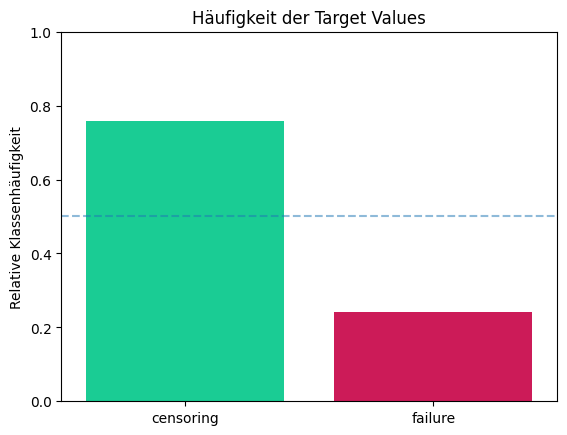

In [34]:
# base rate
# 1 = failure, 0 = censoring
mapping = {0:"censoring",1:"failure"} 
plt.bar(y_train.value_counts().index,y_train.value_counts()/y_train.shape[0],tick_label=y_train.value_counts().index.map(mapping),color=["#1ACC94","#CC1B58"])
plt.hlines(0.5,-0.5,1.5,ls="--",alpha=0.5)
plt.xlim(-0.5,1.5)
plt.ylim(0,1)
plt.title("Häufigkeit der Target Values")
plt.ylabel("Relative Klassenhäufigkeit")
plt.show()

In [35]:
#Entropie

merged_dataframe = pd.concat([X_train,y_train],axis=1)

# Für jedes Attribut (jede Spalte) im Inputdatensatz
for column in X_train:
    # Für jede unqiue Ausprägung in der aktuellen Spalte
    for unique_value in X_train[column].unique():
        entropy_values = []
        # entropy_values uniquen Ausprägungen in Y (0 und 1 in diesem Fall)
        for target_value in y_train.unique():
            pi = merged_dataframe.loc[(merged_dataframe[column] == unique_value) & (merged_dataframe["cid"] == target_value)].shape[0]/merged_dataframe.loc[(merged_dataframe[column] == unique_value)].shape[0]
            entropy_values.append(pi*np.log2(pi))
        entropy = -np.sum(entropy_values)
        print("Entropie für Attribut {} = {}: {:.2f}".format(column,unique_value,entropy))

Entropie für Attribut age = 0.48275862068965525: 0.76
Entropie für Attribut age = 0.4655172413793104: 0.84
Entropie für Attribut age = 0.3275862068965517: 0.78
Entropie für Attribut age = 0.9137931034482758: 1.00
Entropie für Attribut age = 0.3448275862068966: 0.79
Entropie für Attribut age = 0.5689655172413793: 0.81
Entropie für Attribut age = 0.5: 0.73
Entropie für Attribut age = 0.22413793103448273: 0.83
Entropie für Attribut age = 0.36206896551724144: 0.70
Entropie für Attribut age = 0.27586206896551724: 0.74
Entropie für Attribut age = 0.4137931034482759: 0.73
Entropie für Attribut age = 0.6551724137931034: 0.85
Entropie für Attribut age = 0.39655172413793105: 0.76
Entropie für Attribut age = 0.5172413793103449: 0.99
Entropie für Attribut age = 0.43103448275862066: 0.86
Entropie für Attribut age = 0.31034482758620696: 0.76
Entropie für Attribut age = 0.3793103448275862: 0.71
Entropie für Attribut age = 0.15517241379310345: 0.79
Entropie für Attribut age = 0.18965517241379312: 0.56

In [38]:
# Information Gain

merged_dataframe = pd.concat([X_train,y_train],axis=1)

# Für jedes Attribut (jede Spalte) im Inputdatensatz
for column in X_train:
    # Für jede unqiue Ausprägung in der aktuellen Spalte
    parent_pi1 = merged_dataframe.loc[merged_dataframe["cid"] == 0].shape[0]/merged_dataframe.shape[0]
    parent_pi2 = merged_dataframe.loc[merged_dataframe["cid"] == 1].shape[0]/merged_dataframe.shape[0]
    parent_entropy = -(parent_pi1*np.log2(parent_pi1)+parent_pi2*np.log2(parent_pi2))

    entropies = []
    for unique_value in X_train[column].unique():
        entropy_values = []
        # Alle uniquen Ausprägungen in Y (0 und 1 in diesem Fall)
        for target_value in y_train.unique():
            pi = merged_dataframe.loc[(merged_dataframe[column] == unique_value) & (merged_dataframe["cid"] == target_value)].shape[0]/merged_dataframe.loc[(merged_dataframe[column] == unique_value)].shape[0]
            entropy_values.append(pi*np.log2(pi))
        entropies.append(np.sum(entropy_values)*-1*merged_dataframe.loc[(merged_dataframe[column] == unique_value)].shape[0]/merged_dataframe.shape[0])
    
    print("Information Gain für Attribut {}:{:.2f}".format(column,parent_entropy-np.sum(entropies)))

Information Gain für Attribut age:nan
Information Gain für Attribut wtkg:nan
Information Gain für Attribut karnof:0.01
Information Gain für Attribut cd40:nan
Information Gain für Attribut trt_ZDV + ddI:0.00
Information Gain für Attribut trt_ZDV only:0.01
Information Gain für Attribut trt_ddI only:0.00
Information Gain für Attribut hemo_no hemophilia:0.00
Information Gain für Attribut homo_no homosexual:0.00
Information Gain für Attribut drugs_no IV drugs use:0.00
Information Gain für Attribut z30_no ZDV-Therapy 30 days befor randomisation:0.01
Information Gain für Attribut race_White:0.00
Information Gain für Attribut gender_Male:0.00
Information Gain für Attribut strat_> 52 weeks:0.01
Information Gain für Attribut strat_Antiretroviral Naive:0.01
Information Gain für Attribut symptom_symtomatic:0.01


In [39]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.5747663551401869

Zwischenfazit DT: 1. die stetigen Parameter sollen wohl kategorisiert werden. 2. für kategoriale - große Entripie, wenig Information gain. ==> noch viel zu tun. 

## Logistische Regression

In [36]:
from sklearn.linear_model import LogisticRegression
# training
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

#prediction
y_pred = logreg.predict(X_test)
print("Accuracy Score: " + str(logreg.score(X_test,y_test)))

Accuracy Score: 0.7289719626168224


## Evaluation

In [37]:

def acu(y_pred,y_test):
    return metrics.accuracy_score(y_test, y_pred)

def train_evaluate_time(method):
    start_time = time.time()
    methods[method].fit(X_train, y_train)
    running_time = round(time.time() - start_time,2)
    model_predict = methods[method].predict(X_test)
    model_acu = acu(model_predict,y_test)
    print("Genauigkeit von {}: {}; running time: {}".format(method, model_acu, running_time))


methods = {"Log Regression": LogisticRegression(), "svm": svm.SVC()}


for method in methods:
    train_evaluate_time(method)

Genauigkeit von Log Regression: 0.7289719626168224; running time: 0.01
Genauigkeit von svm: 0.7242990654205608; running time: 0.12


## Interpretation

In [ ]:
import matplotlib as plt
# Shap value nehmen
explainer = shap.KernelExplainer(methods["svm"].predict, X_train)
shap_values = explainer.shap_values(X_test)
#shap_sample = explainer.shap.sample(X_test, 150)
plt.figure(figsize=(10,10))
plt.title("SHAP Values: {}".format(method))
shap.summary_plot(shap_sample, X_train)
plt.show()

Using 1497 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 3/642 [09:26<33:37:38, 189.45s/it]